In [682]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import joblib

In [683]:
train_df = pd.read_csv('Домашнее задание 3 (урок 6)/HW_6_data.csv', parse_dates=['dates'])
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          1976 non-null   datetime64[ns]
 1   SKU            1976 non-null   int64         
 2   price_per_sku  1976 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 46.4 KB


,dates,SKU,price_per_sku
0,2018-11-05,12538,137.0
1,2018-11-08,12538,137.0
2,2018-11-09,12538,137.0
3,2018-11-10,12538,137.0
4,2018-11-11,12538,137.0


In [684]:
test_df = pd.read_csv('Домашнее задание 3 (урок 6)/HW_6_test.csv', parse_dates=['dates'])
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SKU     36 non-null     int64         
 1   dates   36 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 704.0 bytes


,SKU,dates
0,12538,2019-12-02
1,12538,2019-12-09
2,12538,2019-12-16
3,12538,2019-12-26
4,18969,2019-03-11


In [685]:
set(test_df.SKU.unique()) - set(train_df.SKU.unique())

set()

In [686]:
train_pivot = train_df.pivot_table(values='price_per_sku', columns='SKU', index='dates')

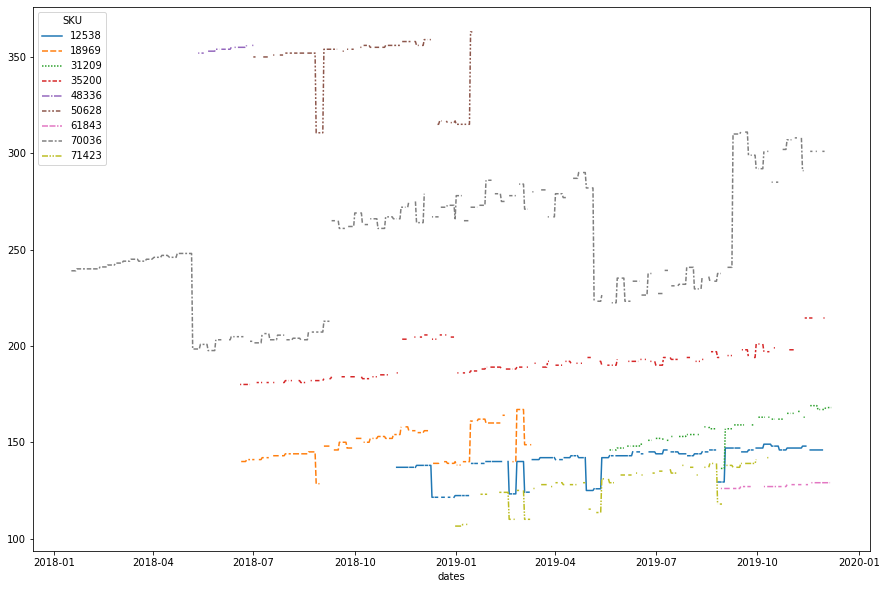

In [687]:
plt.figure(figsize=(15,10))
sns.lineplot(data=train_pivot);

In [688]:
output_df = test_df.copy(deep=True)
output_df['predicted_lower_bound'] = -1
output_df['predicted_upper_bound'] = -1
output_df.sort_values(by='dates', inplace=True)
output_df.head()

,SKU,dates,predicted_lower_bound,predicted_upper_bound
16,48336,2018-07-02,-1,-1
17,48336,2018-07-09,-1,-1
18,48336,2018-07-16,-1,-1
19,48336,2018-07-23,-1,-1
20,50628,2019-01-23,-1,-1


In [689]:
def get_sub_df(df, sku):
    inds = df.SKU == sku
    return df[inds].sort_values(by='dates')

In [690]:
def prepare_df(df, train_size=0.8):
    train_threshold = int(0.8*len(df))
    print(f"train_threshold: {train_threshold}")
    train_set = df[:train_threshold]
    test_set = df[train_threshold:]
    print(f"Train shape: {train_set.shape}; Test shape: {test_set.shape}")
    
    fig = plt.figure(figsize=(10,10));
    ax = fig.add_subplot(2,1,1);
    pd.plotting.autocorrelation_plot(train_set.price_per_sku.values, ax=ax);
    
    ax = fig.add_subplot(2,1,2);
    lags = int(0.2*len(train_set.price_per_sku.values))
    print(f"PACF lags: {lags}")
    plot_pacf(train_set.price_per_sku.values, 
              lags=lags, ax=ax);
    
    return fig, train_set, test_set

In [691]:
def calculate_error(y, prediction_bounds):
    assert len(y) == len(prediction_bounds), 'Different Length'
    scaler = MinMaxScaler()
    scaler.fit(prediction_bounds.T)
    y_scaled = scaler.transform(y.reshape(1,-1))
    return np.mean(np.abs(y_scaled - 0.5))

In [692]:
arima_params_per_sku = {}

In [693]:
#joblib.dump(arima_params_per_sku, 'arima_params_per_sku.j')

In [694]:
test_df.SKU.unique()

array([12538, 18969, 31209, 35200, 48336, 50628, 61843, 70036, 71423],
      dtype=int64)

# Start Here

In [926]:
### Modify This
sku = test_df.SKU.unique()[8] #5
sku

71423

In [927]:
sub_df_train = get_sub_df(train_df, sku)

sub_df_test = get_sub_df(test_df, sku)

In [928]:
sub_df_train

,dates,SKU,price_per_sku
1800,2018-12-31,71423,106.48
1801,2019-01-01,71423,106.48
1802,2019-01-02,71423,106.48
1803,2019-01-03,71423,106.48
1804,2019-01-04,71423,106.48
...,...,...,...
1971,2019-10-03,71423,141.00
1972,2019-10-05,71423,141.00
1973,2019-10-10,71423,142.00
1974,2019-10-11,71423,142.00


In [929]:
sub_df_test

,SKU,dates
32,71423,2019-10-15
33,71423,2019-10-21
34,71423,2019-10-28
35,71423,2019-11-04


In [930]:
# plt.figure(figsize=(10,5))
# pd.plotting.autocorrelation_plot(train_sub_df.price_per_sku.values)
# plot_pacf(train_sub_df.price_per_sku.values, lags=50);

train_threshold: 140
Train shape: (140, 3); Test shape: (36, 3)
PACF lags: 28


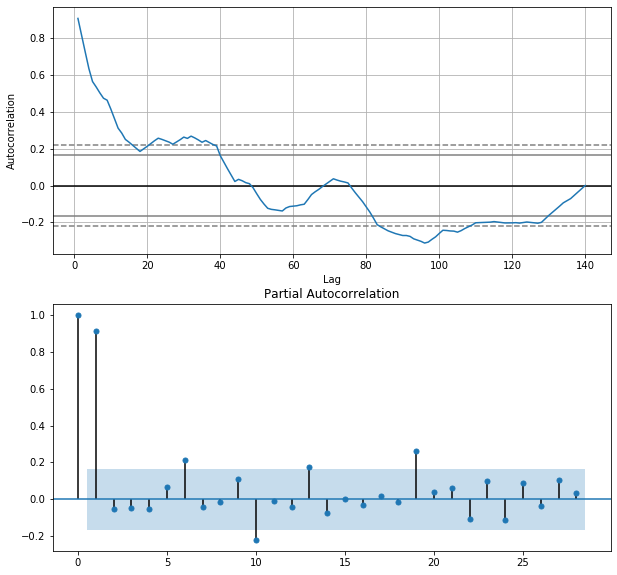

In [931]:
fig, sub_df_trainval, sub_df_val = prepare_df(sub_df_train)

In [950]:
# Modify This
arima_params_per_sku[sku] = (2,1,10)
arima_params_per_sku

{12538: (2, 1, 10),
 18969: (4, 1, 15),
 31209: (3, 1, 20),
 35200: (4, 1, 15),
 48336: (2, 1, 4),
 50628: (2, 1, 4),
 61843: (3, 1, 4),
 70036: (4, 1, 15),
 71423: (2, 1, 10)}

In [951]:
significance_level = 0.05

def arima_fit_predict(train_set, test_set, order, significance_level):
    ARIMA_ = ARIMA(train_set.price_per_sku.values, order=order)
    model = ARIMA_.fit()
    return model.get_forecast(len(test_set)).conf_int(significance_level)

In [952]:
prediction_bounds_val = arima_fit_predict(sub_df_trainval, sub_df_val, 
                                          arima_params_per_sku[sku], significance_level)

sub_y = sub_df_val.price_per_sku.values

calculate_error(sub_y, prediction_bounds_val)

C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.13722194924807984

In [953]:
# ARIMA_ = ARIMA(sub_df_train.price_per_sku.values, order=arima_params_per_sku[sku])
# ARIMA_full_model = ARIMA_.fit()

prediction_bounds = arima_fit_predict(sub_df_train, sub_df_test, 
                                          arima_params_per_sku[sku], significance_level)

C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [954]:
output_df.loc[output_df.SKU == sku, ['predicted_lower_bound', 'predicted_upper_bound']] = prediction_bounds

# Looping

train_threshold: 256
Train shape: (256, 3); Test shape: (64, 3)
PACF lags: 51


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SKU: 12538; Error: 0.27536150598143216


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


train_threshold: 172
Train shape: (172, 3); Test shape: (43, 3)
PACF lags: 34


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SKU: 18969; Error: 0.6706402436623807


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


train_threshold: 118
Train shape: (118, 3); Test shape: (30, 3)
PACF lags: 23


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SKU: 31209; Error: 0.976496679678964


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


train_threshold: 257
Train shape: (257, 3); Test shape: (65, 3)
PACF lags: 51


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SKU: 35200; Error: 1.5853325026706016


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


train_threshold: 31
Train shape: (31, 3); Test shape: (8, 3)
PACF lags: 6
SKU: 48336; Error: 9.804862845068298
train_threshold: 124
Train shape: (124, 3); Test shape: (32, 3)
PACF lags: 24
SKU: 50628; Error: 6.030212865796722
train_threshold: 57
Train shape: (57, 3); Test shape: (15, 3)
PACF lags: 11
SKU: 61843; Error: 0.2765752412778092
train_threshold: 422
Train shape: (422, 3); Test shape: (106, 3)
PACF lags: 84


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SKU: 70036; Error: 2.738130267408144


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


train_threshold: 140
Train shape: (140, 3); Test shape: (36, 3)
PACF lags: 28
SKU: 71423; Error: 0.14425946576961687


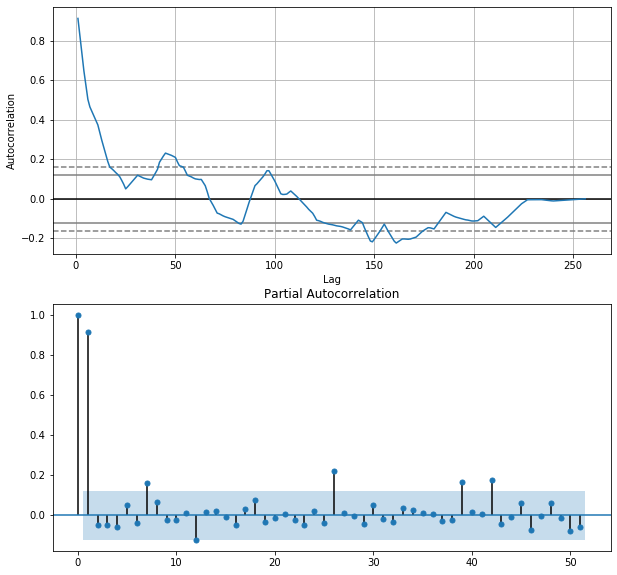

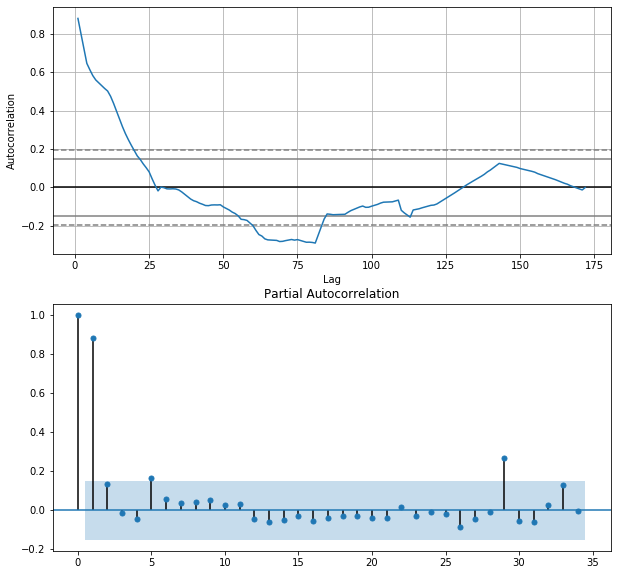

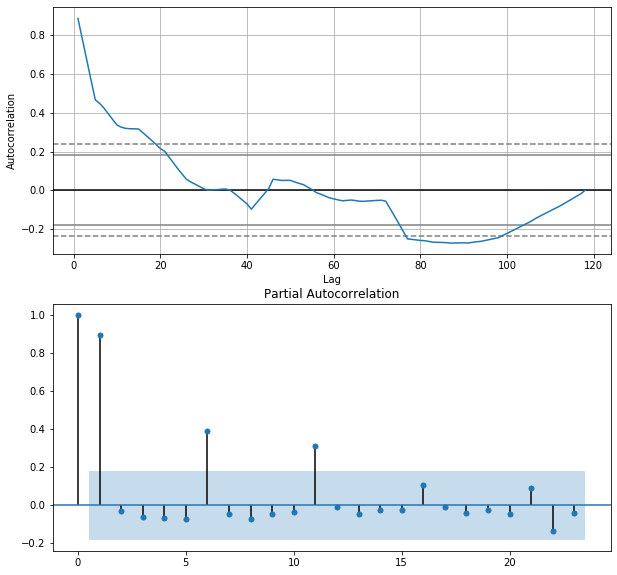

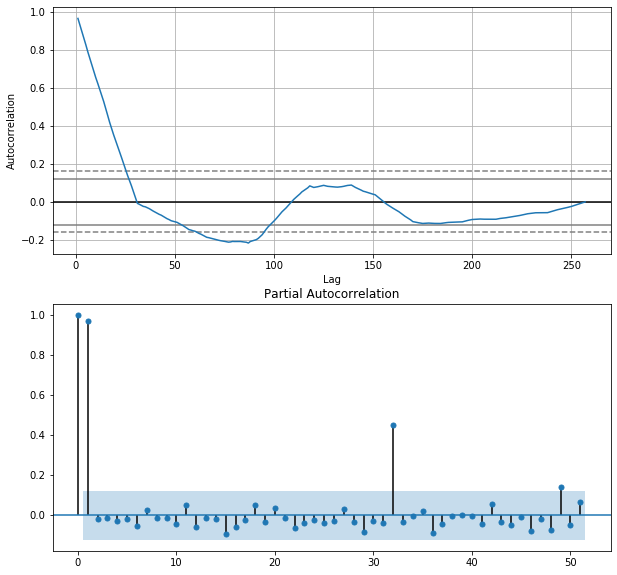

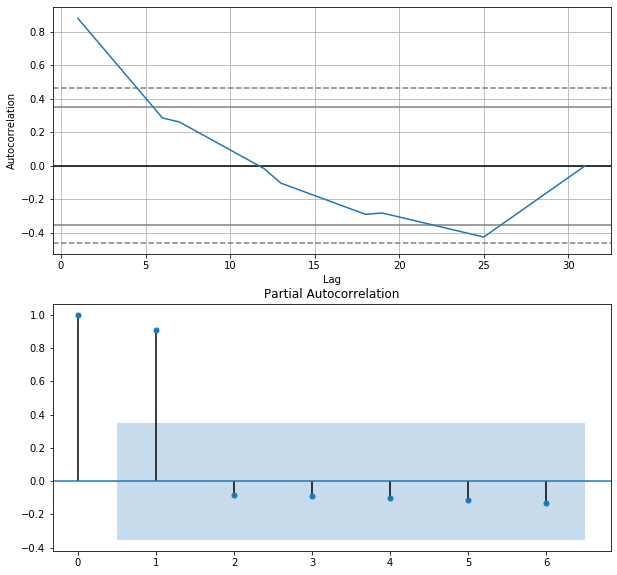

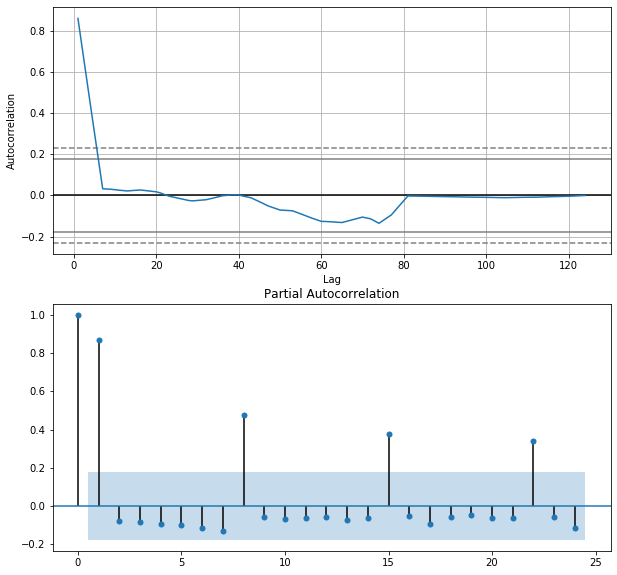

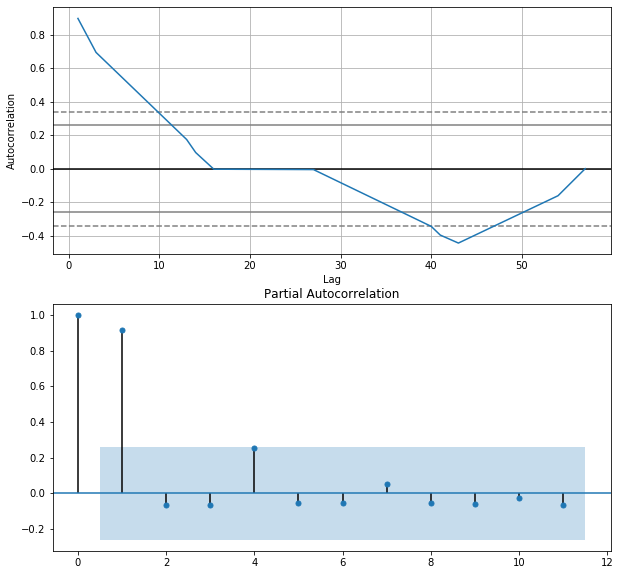

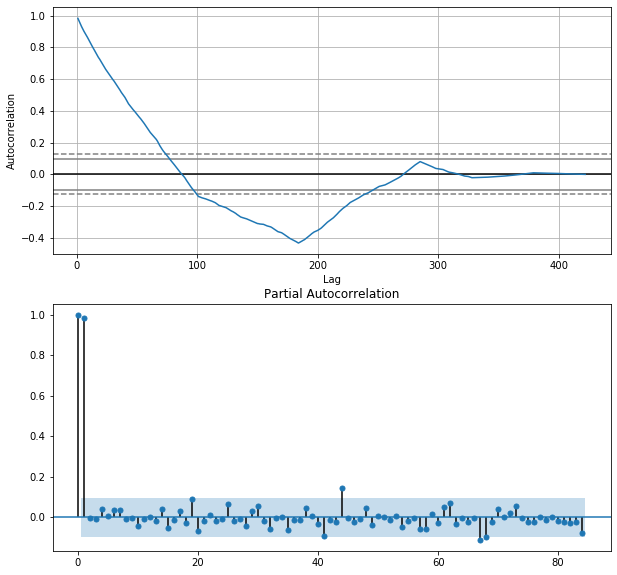

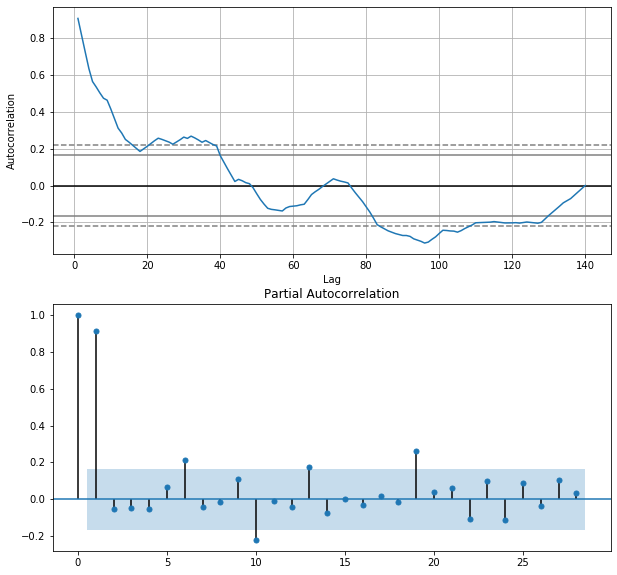

In [681]:
significance_level = 0.05

for sku in test_df.SKU.unique():
    sub_df_train = get_sub_df(train_df, sku)
    sub_df_test = get_sub_df(test_df, sku)
    
    fig, sub_df_trainval, sub_df_val = prepare_df(sub_df_train)
    
    # validation
    prediction_bounds_val = arima_fit_predict(sub_df_trainval, sub_df_val, 
                                              arima_params_per_sku[sku], significance_level)
    sub_y_val = sub_df_val.price_per_sku.values

    print(f"SKU: {sku}; Error: {calculate_error(sub_y_val, prediction_bounds_val)}")
    
    prediction_bounds_full = arima_fit_predict(sub_df_train, sub_df_test, 
                                               arima_params_per_sku[sku], significance_level)
    output_df.loc[output_df.SKU == sku, ['predicted_lower_bound', 'predicted_upper_bound']] = prediction_bounds_full

In [955]:
output_df.to_csv('part2.csv', index=False)